In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import mean_squared_error as mse

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#choose case 1 or 2
case = 1
# number of leading cars that are used for the labels
car = 0
n_leading_cars = 2

# load pre processed data
data_dir = "processed/"
t = np.loadtxt(data_dir+"case"+str(case)+"/time.txt")
Dx = np.loadtxt(data_dir+"case"+str(case)+"/headway.txt")
dotx = np.loadtxt(data_dir+"case"+str(case)+"/velocity.txt")
ddotx = np.loadtxt(data_dir+"case"+str(case)+"/acceleration.txt")
D_dotx = np.loadtxt(data_dir+"case"+str(case)+"/velocity_difference.txt")

range_state = [Dx.min(),Dx.max(),D_dotx.min(),D_dotx.max(),dotx.min(),dotx.max()]

def gen_traindata():
    # pre-arrays for features, filled with data to predict acceleration 
    #t = np.array(t[car,:]).reshape(-1,1)
    Dx_append = np.array(Dx[car,:]).reshape(-1,1)
    dotx_append = np.array(dotx[car,:]).reshape(-1,1)
    D_dotx_append = np.array(D_dotx[car,:]).reshape(-1,1)
    # pre-array for labels, filled with acceleration
    ddotx_append = np.array(ddotx[car,:]).reshape(-1,1)
    x=np.concatenate((Dx_append,D_dotx_append,dotx_append),axis=1)
    y=ddotx_append
    return x,y

x, y = gen_traindata()

In [3]:
def sliding_windows(x_data,y_data, seq_length):
    x = []
    y = []

    for i in range(len(x_data)-seq_length-1):
        _x = x_data[i:(i+seq_length+1)]
        _y = y_data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler(feature_range=(0.5, 1.5))
training_data = sc.fit_transform(x)
seq_length = 6
train_x, train_y = sliding_windows(training_data, y, seq_length-1)
train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(train_x)))
dataY = Variable(torch.Tensor(np.array(train_y)))

trainX = Variable(torch.Tensor(np.array(train_x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(train_y[0:train_size])))

testX = Variable(torch.Tensor(np.array(train_x[train_size:len(train_x)])))
testY = Variable(torch.Tensor(np.array(train_y[train_size:len(train_y)])))

In [4]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

        self.apply(self.weight_init)
        
    
    def weight_init(self,m):
        if isinstance(m,nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias,0)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size, device=x.device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size, device=x.device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [5]:
class OVM(nn.Module):
    def __init__(self):
        super(OVM,self).__init__()
        self.hc = nn.Parameter(torch.tensor(3., requires_grad=True))
        self.k = nn.Parameter(torch.tensor(3., requires_grad=True))
        self.vmax = nn.Parameter(torch.tensor(3., requires_grad=True))
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        a = self.k*(x[:,2]-0.5*self.vmax*self.tanh(x[:,0]-self.hc)+self.tanh(self.hc))
        return a.view(-1,1)
        
class IDM(nn.Module):
    def __init__(self):
        super(IDM,self).__init__()
        self.amax = nn.Parameter(torch.tensor(1., requires_grad=True))
        self.b = nn.Parameter(torch.tensor(1., requires_grad=True))
        self.T0 = nn.Parameter(torch.tensor(1., requires_grad=True))
        self.s0 = nn.Parameter(torch.tensor(1., requires_grad=True))
        self.v0 = nn.Parameter(torch.tensor(1., requires_grad=True))
        self.sigma = nn.Parameter(torch.tensor(4., requires_grad=False))
        
    def forward(self,x):
        s_star = self.s0+x[:,2]*self.T0+x[:,1]*x[:,2]/(2*torch.sqrt(self.amax*self.b))
        transi_1 = x[:,2]/self.v0
        transi_2 = s_star/x[:,0]
        a = self.amax*(1-transi_1.pow(self.sigma)-transi_2.pow(2))
        
        return a.view(-1,1)
    

In [6]:
def train_single_model(mode,epoch,epoch_disp, lr):
    num_epochs = epoch
    learning_rate = lr

    input_size = 3
    hidden_size = 2
    num_layers = 1
    num_classes = 1

    if mode == 'lstm':
        model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    elif mode == 'ovm':
        model = OVM().to(device)
    elif mode == 'idm':
        model = IDM().to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    print('****** '+mode+' training ******')
    for epoch in range(num_epochs+1):
        if mode == 'lstm':
            outputs = model(trainX.to(device))
        else:
            outputs = model(trainX[:,-1,:].to(device))
        optimizer.zero_grad()

        # obtain the loss function
        loss = criterion(outputs, trainY.to(device))

        loss.backward()

        optimizer.step()
        if epoch % epoch_disp == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    torch.save(model.state_dict(),"/openbayes/home/neural-network-car-following-model-master/net/"+mode+".pt")
    return model
        
def display(model, mode):
    model.eval()
    if mode == 'ovm' or mode == 'idm':
        train_predict = model(dataX[:,-1,:].to(device))
        test_predict = model(testX[:,-1,:].to(device)).cpu().data.numpy()
    else:
        train_predict = model(dataX.to(device))
        test_predict = model(testX.to(device)).cpu().data.numpy()

    data_predict = train_predict.cpu().data.numpy()
    dataY_plot = dataY.data.numpy()
    test_Y = testY.data.numpy()
    
    plt.axvline(x=train_size, c='r', linestyle='--')
    plt.plot(dataY_plot)
    plt.plot(data_predict)
    plt.suptitle(mode + ' test mse: ' + str(mse(test_Y, test_predict)))
    plt.show()

In [7]:
def PINN_seperate_train(calibration_model,alpha=0.8,mode='idm',epoch=50000, lr=0.001,epoch_disp=10000):
    calibration_model.eval()
    num_epochs = epoch
    learning_rate_lstm = lr

    input_size = 3
    hidden_size = 2
    num_layers = 1
    num_classes = 1
    
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate_lstm)
    torch.manual_seed(2022) 
    collocX = torch.rand(trainX.shape)+0.5*torch.ones(trainX.shape)
    # Train the model
    print('****** pinn_seperate_'+mode+' training ******')
    for epoch in range(num_epochs+1):
        outputs_calibration_colloc = calibration_model(collocX[:,-1,:].to(device))
        outputs_lstm_colloc = lstm(collocX.to(device))
        outputs_lstm_train = lstm(trainX.to(device))
        
        loss = alpha*criterion(outputs_lstm_train, trainY.to(device))+(1-alpha)*criterion(outputs_calibration_colloc, outputs_lstm_colloc)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(lstm.parameters(), max_norm=20, norm_type=2)
        
        optimizer.step()
        
        if epoch % epoch_disp == 0:
            print("Epoch: %d, loss_lstm: %1.5f" % (epoch, loss.item()))
    torch.save(lstm.state_dict(),"/openbayes/home/neural-network-car-following-model-master/net/pinn_sep_"+mode+".pt")
    return lstm

In [8]:
def PINN_joint_train(alpha=0.8,mode='idm',epoch=50000, lr_p=0.01, lr_lstm=0.001,epoch_disp=10000):
    num_epochs = epoch
    learning_rate_p_model = lr_p
    learning_rate_lstm = lr_lstm

    input_size = 3
    hidden_size = 2
    num_layers = 1
    num_classes = 1
    
    if mode == 'idm':
        p_model = IDM().to(device)
    elif mode == 'ovm':
        p_model = OVM().to(device)
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer_p_model = torch.optim.Adam(p_model.parameters(), lr=learning_rate_p_model)
    optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=learning_rate_lstm)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
    torch.manual_seed(2022) 
    collocX = torch.rand(trainX.shape)+0.5*torch.ones(trainX.shape)
    # Train the model
    print('****** pinn_joint_'+mode+' training ******')
    for epoch in range(num_epochs+1):
        optimizer_p_model.zero_grad()
        
        outputs_p_model_colloc = p_model(collocX[:,-1,:].to(device))
        outputs_lstm_colloc = lstm(collocX.to(device))
        
        loss_p_model = criterion(outputs_p_model_colloc, outputs_lstm_colloc)
        loss_p_model.backward(retain_graph=True)
        clip_grad_norm_(p_model.parameters(), max_norm=20, norm_type=2)
        
        
        optimizer_lstm.zero_grad()
        outputs_lstm_train = lstm(trainX.to(device))
        loss_lstm = alpha*criterion(outputs_lstm_train, trainY.to(device))+(1-alpha)*criterion(outputs_p_model_colloc, outputs_lstm_colloc)
        loss_lstm.backward()
        clip_grad_norm_(lstm.parameters(), max_norm=20, norm_type=2)
        
        optimizer_p_model.step()
        optimizer_lstm.step()
        
        if epoch % epoch_disp == 0:
          print("Epoch: %d, loss_lstm: %1.5f, loss_physics: %1.5f" % (epoch, loss_lstm.item(), loss_p_model.item()))
    torch.save(lstm.state_dict(),"/openbayes/home/neural-network-car-following-model-master/net/pinn_joint_"+mode+".pt")
    return p_model, lstm

In [9]:
lstm = train_single_model('lstm',100000,10000, 0.001)
ovm = train_single_model('ovm',50000,10000, 0.003)
idm = train_single_model('idm',50000,10000, 0.01)
pinn_seperate_ovm = PINN_seperate_train(calibration_model=ovm ,mode='ovm', epoch=100000, lr=0.001, epoch_disp=10000)
pinn_seperate_idm = PINN_seperate_train(calibration_model=idm,mode='idm', epoch=100000, lr=0.001, epoch_disp=10000)
_, pinn_joint_ovm = PINN_joint_train(mode='ovm', epoch=100000, lr_p=0.01, lr_lstm=0.001, epoch_disp=10000)
_, pinn_joint_idm = PINN_joint_train(mode='idm', epoch=100000, lr_p=0.01, lr_lstm=0.001, epoch_disp=10000)

****** lstm training ******
Epoch: 0, loss: 0.80075
Epoch: 10000, loss: 0.40914
Epoch: 20000, loss: 0.34110
Epoch: 30000, loss: 0.33425
Epoch: 40000, loss: 0.33129
Epoch: 50000, loss: 0.32853
Epoch: 60000, loss: 0.32640
Epoch: 70000, loss: 0.32442
Epoch: 80000, loss: 0.32385
Epoch: 90000, loss: 0.32356
Epoch: 100000, loss: 0.32331
****** ovm training ******
Epoch: 0, loss: 119.56573
Epoch: 10000, loss: 0.72814
Epoch: 20000, loss: 0.63385
Epoch: 30000, loss: 0.63385
Epoch: 40000, loss: 0.63385
Epoch: 50000, loss: 0.63385
****** idm training ******
Epoch: 0, loss: 277.18655
Epoch: 10000, loss: 0.52916
Epoch: 20000, loss: 0.51673
Epoch: 30000, loss: 0.51506
Epoch: 40000, loss: 0.51485
Epoch: 50000, loss: 0.51481
****** pinn_seperate_ovm training ******
Epoch: 0, loss_lstm: 2.09929
Epoch: 10000, loss_lstm: 0.36529
Epoch: 20000, loss_lstm: 0.34318
Epoch: 30000, loss_lstm: 0.33469
Epoch: 40000, loss_lstm: 0.32976
Epoch: 50000, loss_lstm: 0.32613
Epoch: 60000, loss_lstm: 0.32314
Epoch: 70000,

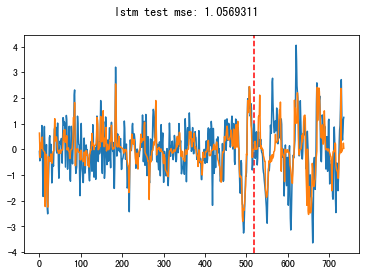

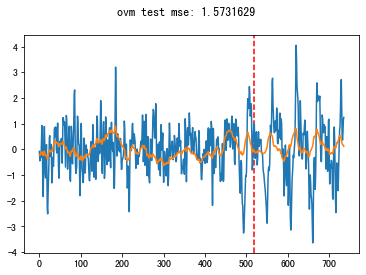

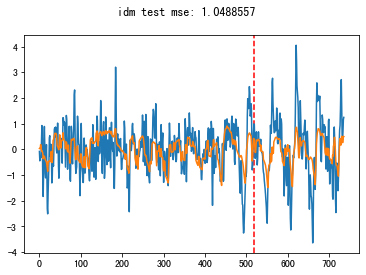

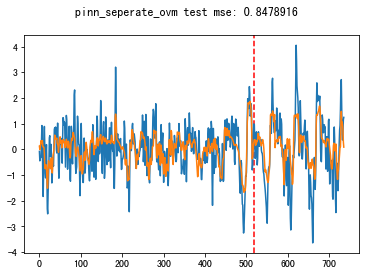

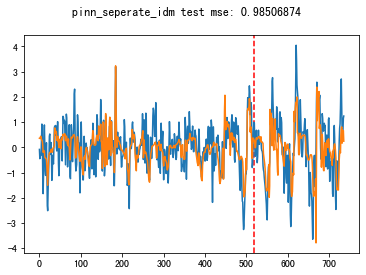

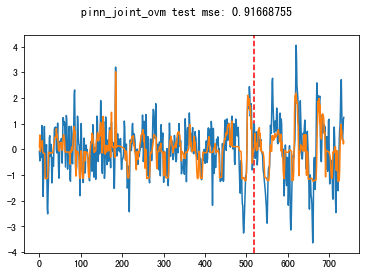

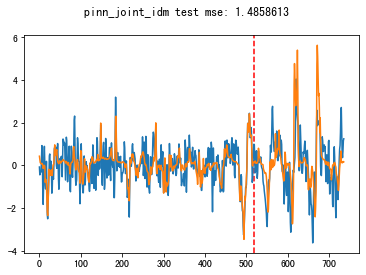

In [10]:
input_size = 3
hidden_size = 2
num_layers = 1
num_classes = 1
    
ovm=OVM().to(device)
ovm.load_state_dict(torch.load("/openbayes/home/neural-network-car-following-model-master/net/ovm.pt"))
idm=IDM().to(device)
idm.load_state_dict(torch.load("/openbayes/home/neural-network-car-following-model-master/net/idm.pt"))
pinn_seperate_ovm=LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
pinn_seperate_ovm.load_state_dict(torch.load("/openbayes/home/neural-network-car-following-model-master/net/pinn_sep_ovm.pt"))
pinn_joint_ovm=LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
pinn_joint_ovm.load_state_dict(torch.load("/openbayes/home/neural-network-car-following-model-master/net/pinn_joint_ovm.pt"))

pinn_seperate_idm=LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
pinn_seperate_idm.load_state_dict(torch.load("/openbayes/home/neural-network-car-following-model-master/net/pinn_sep_idm.pt"))
pinn_joint_idm=LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
pinn_joint_idm.load_state_dict(torch.load("/openbayes/home/neural-network-car-following-model-master/net/pinn_joint_idm.pt"))

display(lstm, 'lstm')
display(ovm, 'ovm')
display(idm, 'idm')
display(pinn_seperate_ovm, 'pinn_seperate_ovm')
display(pinn_seperate_idm, 'pinn_seperate_idm')
display(pinn_joint_ovm, 'pinn_joint_ovm')
display(pinn_joint_idm, 'pinn_joint_idm')

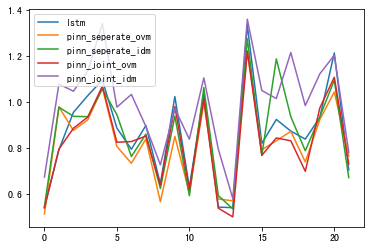

In [11]:
lstm_ls=[]
pinn_seperate_ovm_ls=[]
pinn_seperate_idm_ls=[]
pinn_joint_ovm_ls=[]
pinn_joint_idm_ls=[]
for car in range(22):
    case = 1
    x1, y1 = gen_traindata()
    x1=sc.transform(x1)
    train_x1, train_y1 = sliding_windows(x1, y1, seq_length-1)
    train_size1 = int(len(y1) * 0.8)
    test_size1 = len(y1) - train_size1

    dataX1 = Variable(torch.Tensor(np.array(train_x1))).to(device)
    dataY1 = Variable(torch.Tensor(np.array(train_y1)))
    lstm_predict1 = lstm(dataX1.to(device)).cpu().data.numpy()
    lstm_ls.append(mse(dataY1,lstm_predict1))
    pinn_seperate_ovm_predict1=pinn_seperate_ovm(dataX1.to(device)).cpu().data.numpy()
    pinn_seperate_ovm_ls.append(mse(dataY1,pinn_seperate_ovm_predict1))
    pinn_seperate_idm_predict1=pinn_seperate_idm(dataX1.to(device)).cpu().data.numpy()
    pinn_seperate_idm_ls.append(mse(dataY1,pinn_seperate_idm_predict1))
    pinn_joint_ovm_predict1=pinn_joint_ovm(dataX1.to(device)).cpu().data.numpy()
    pinn_joint_ovm_ls.append(mse(dataY1,pinn_joint_ovm_predict1))
    pinn_joint_idm_predict1=pinn_joint_idm(dataX1.to(device)).cpu().data.numpy()
    pinn_joint_idm_ls.append(mse(dataY1,pinn_joint_idm_predict1))
    
plt.plot(lstm_ls)
plt.plot(pinn_seperate_ovm_ls)
plt.plot(pinn_seperate_idm_ls)
plt.plot(pinn_joint_ovm_ls)
plt.plot(pinn_joint_idm_ls)
plt.legend(['lstm','pinn_seperate_ovm','pinn_seperate_idm','pinn_joint_ovm','pinn_joint_idm'])